# Build Probabilistic Machine Learning Apps Using Streamlit

## with PyMC3


<table>
    <tr>
        <td>
            <a href="https://docs.pymc.io/"><img src="https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg" width="600"></a>
            <br>
        </td>
        <td>
            <a href="https://www.streamlit.io/"><img src="https://assets.website-files.com/5dc3b47ddc6c0c2a1af74ad0/5e18182db827fa0659541754_RGB_Logo_Vertical_Color_Light_Bg.png" width="400"></a>
        </td>
    </tr>
</table>





## [@emaasit](https://twitter.com/emaasit) &#8226; [Bayesian Data Science DC Meetup](https://www.meetup.com/Bayesian-Data-Science-DC/events/270623940) &#8226; Washington, D.C. &#8226; 05/27/2020

## Materials

**Download slides & code from Github: [bit.ly/intro-pml-streamlit](bit.ly/intro-pml-streamlit)**

## Objective

* Target audience: Data Scientists, Analysts, ... Basically anyone who works with data

* Put your analyses in the hands of end users quickly

## Machine Learning: A Probabilistic Perspective

* Probabilistic ML:

 * An Interdisciplinary field that develops both the mathematical foundations and practical applications of systems that learn models of data. (*Ghahramani, 2018*)
 
 
 <center>
    <img src="https://s3.amazonaws.com/media-p.slid.es/uploads/615976/images/4851374/Screen_Shot_2018-04-25_at_1.17.31_PM.png" width=300>
</center>

## Probabilistic Models

* A Model:

 * A model describes data that one could observe from a system (*Ghahramani, 2014*)

<center>
    <img src="https://s3.amazonaws.com/media-p.slid.es/uploads/615976/images/4852150/Screen_Shot_2018-04-25_at_4.23.08_PM.png" width=300>
</center>

<center>
    <img src="https://s3.amazonaws.com/media-p.slid.es/uploads/615976/images/4852138/Screen_Shot_2018-04-25_at_4.20.00_PM.png" width=300>
</center>

  * Use the mathematics of probability theory to express all forms of uncertainty

<center>
    <img src="https://i.ibb.co/g7Nkkwp/Screen-Shot-2020-05-26-at-10-27-04-PM.png" width=1200>
</center>



$$P(\theta \mid y) = \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$$

Where: $\mathbf{\theta}$ = parameters e.g. reproductive metric of an epidemic

* $p(\mathbf{\theta} \mid \textbf{y})$ = posterior over the parameters, given observed data

* $p(\mathbf{\theta})$ = prior over the parameters

* $p(\textbf{y} \mid \mathbf{\theta})$ = likelihood given the covariates & parameters

* $p(\textbf{y})$ = data distribution to ensure normalization

## Case Study: Modeling the COVID-19 Reproduction Metric ,$R_t$,  using Gaussian Processes


$R_t$ = the effective reproduction number in an epidemic. 

* a measure of the number of people who become infected per infectious person at time $t$.


**Reference**: [Bettencourt, L. M., & Ribeiro, R. M. (2008). Real time bayesian estimation of the epidemic potential of emerging infectious diseases. PLoS One, 3(5)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185).

Let's set some setting for this Jupyter Notebook.

In [67]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import plotly.express as px
import pickle
import matplotlib.pyplot as plt
from pymc3.gp.util import plot_gp_dist
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step 1: Prepare the data

* Reference: Kevin Systrom (2020). The Metric We Need to Manage COVID-19
Rt: the effective reproduction number. http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/

    * **HISTORIC STATE DAILY** data from **https://covidtracking.com/api/v1/states/daily.csv**
    
    * **ONSET** & **DELAY** data from **Institute for Health Metrics and Evaluation, University of Washington** https://github.com/beoutbreakprepared/nCoV2019

In [133]:
# Historic state daily data
states = pd.read_csv('data/states.csv', 
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

In [65]:
np.unique(np.array(states.index.get_level_values(0)))

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [28]:
states.head(n=6)

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   
      2020-03-11       0.0      46.0     14.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   
      2020-03-11                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   
      2020-03-11                    NaN                     NaN        NaN   

                  ... hospitalized total totalTestResults posNeg  fips  \
state date        ...                                                    
AK    2020-03-06  ...          NaN     9                8      8     2   
      2020-03-07  ...          NaN    14               12     12     2   
      2020-03-08  ...          NaN    20               14     14     2   
      2020-03-09  ...          NaN    32               23     23     2   
      2020-03-10  ...          NaN    32               23     23     2   
      2020-03-11  ...          NaN    60               46     46     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   
      2020-03-11            0.0                   0.0              23.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  
      2020-03-11               0.0                      23.0  

[6 rows x 25 columns]

In [134]:
state = "CA"
states.xs(state).head(n=6)

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,515,515,515,6,NaN,NaN,NaN,NaN,NaN
2020-03-05,53.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,515,515,515,6,0.0,0.0,0.0,0.0,0.0
2020-03-06,60.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,522,522,522,6,0.0,0.0,0.0,7.0,7.0
2020-03-07,69.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,531,531,531,6,0.0,0.0,0.0,9.0,9.0
2020-03-08,88.0,462.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,550,550,550,6,0.0,0.0,0.0,19.0,19.0
2020-03-09,114.0,690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,804,804,804,6,0.0,0.0,228.0,26.0,254.0


In [135]:
confirmed = states.xs(state).positive.diff().dropna()
confirmed.head(n=5)

date
2020-03-05     0.0
2020-03-06     7.0
2020-03-07     9.0
2020-03-08    19.0
2020-03-09    26.0
Name: positive, dtype: float64

In [ ]:
confirmed = pd.DataFrame(confirmed).reset_index()
confirmed.head(n=5)
confirmed.to_csv('data/confirmed.csv')

In [114]:
onset = pd.read_csv('data/onset.csv', parse_dates=['date'])
onset.tail(n=6)

,Unnamed: 0,date,onset
141,141,2020-05-20,694.333899
142,142,2020-05-21,511.864452
143,143,2020-05-22,355.491271
144,144,2020-05-23,208.181377
145,145,2020-05-24,91.134093
146,146,2020-05-25,12.098933


In [7]:
adjusted = pd.read_csv('data/adjusted_onset.csv', parse_dates=['date'])
adjusted

,Unnamed: 0,date,adjusted_onset
0,0,2019-12-31,0.000000
1,1,2020-01-01,0.001697
2,2,2020-01-02,0.002182
3,3,2020-01-03,0.004607
4,4,2020-01-04,0.006305
...,...,...,...
142,142,2020-05-21,2067.511263
143,143,2020-05-22,2019.347107
144,144,2020-05-23,1960.136986
145,145,2020-05-24,1879.185000


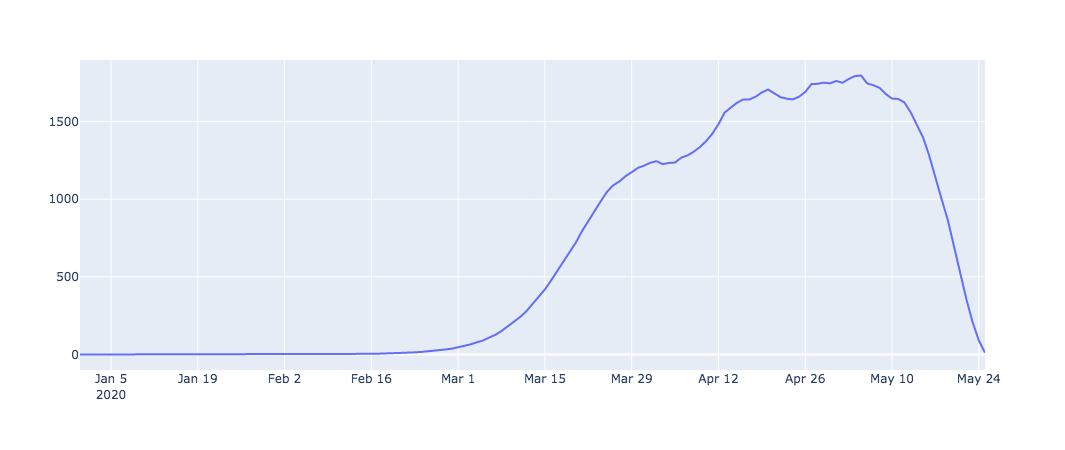

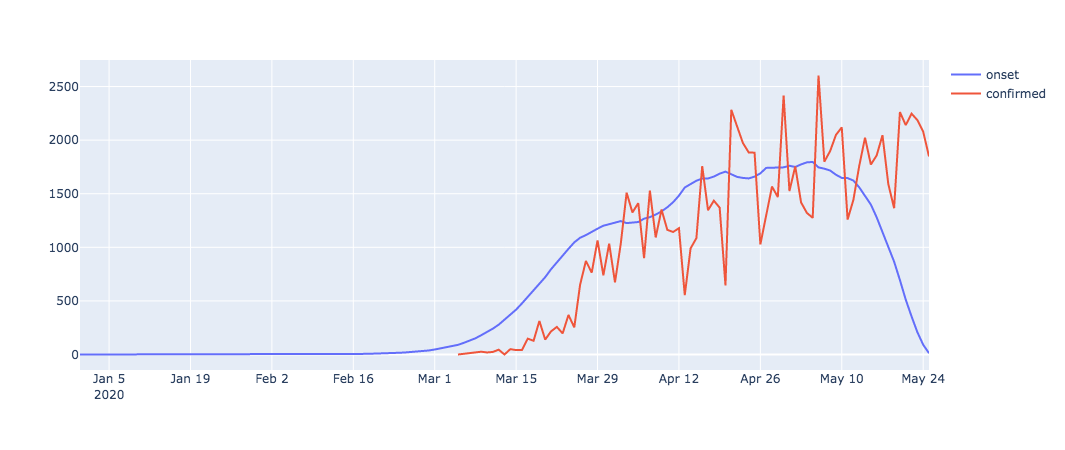

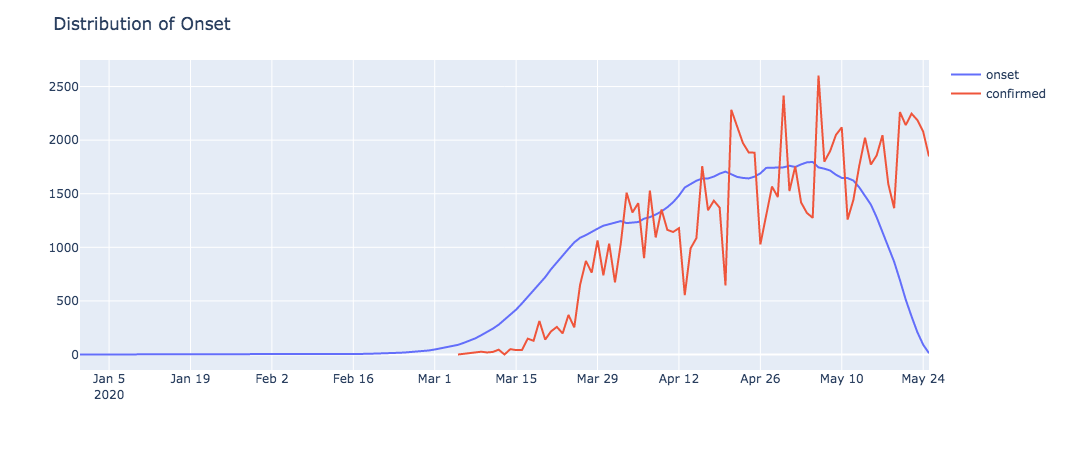

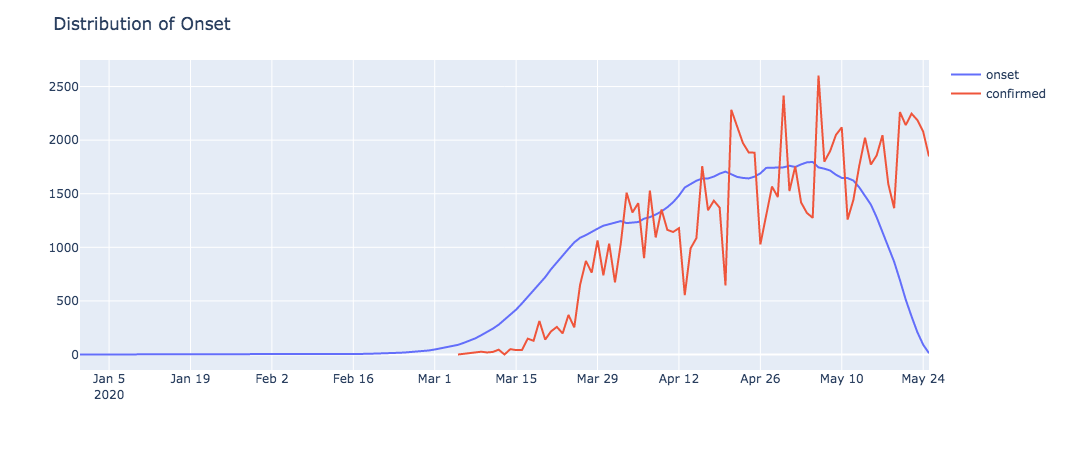

In [126]:
fig1 = px.line()
fig1.add_scatter(x=onset.date, y=onset.onset, mode='lines', name='onset')
# fig.add_scatter(x=adjusted.date, y=adjusted.adjusted_onset, mode='lines')
fig1.add_scatter(x=confirmed.date, y=confirmed.positive, mode='lines', name="confirmed")
fig1.update_layout(
    title="Distribution of Onset",)
fig1.show()

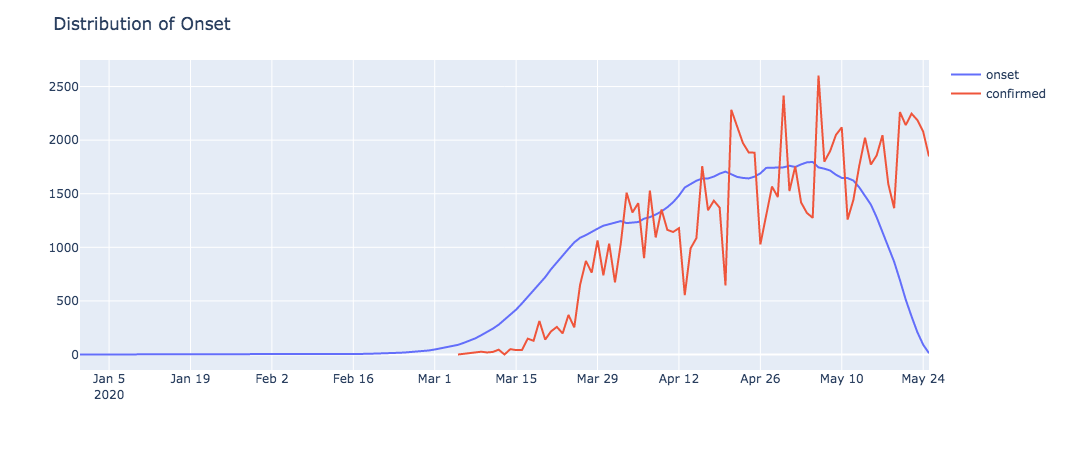

In [127]:
fig1

In [128]:
cumulative_p_delay = pd.read_csv('data/cumulative_p_delay.csv')
cumulative_p_delay.head(n=6)

,Unnamed: 0,cumulative_p_delay
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
5,5,1.0


In [10]:
X_shape = len(onset) - 1

# The inputs to the GP, they must be arranged as a column vector
X = np.arange(X_shape)[:, None]
X.shape

(146, 1)

In [11]:
# The observed data
y = onset.onset.round().values[1:]
y.shape

(146,)

In [12]:
z = onset["onset"].values[:-1]
z.shape

(146,)

In [13]:
w = cumulative_p_delay["cumulative_p_delay"][:-1]
w.shape

(146,)

In [103]:
inferred_yesterday = onset["onset"].values[:-1] / cumulative_p_delay["cumulative_p_delay"][:-1]

In [104]:
inferred_yesterday

0         0.000000
1         0.001697
2         0.002182
3         0.004607
4         0.006305
          ...     
141    2082.496727
142    2067.511263
143    2019.347107
144    1960.136986
145    1879.185000
Name: cumulative_p_delay, Length: 146, dtype: float64

In [105]:
expected_today = inferred_yesterday * cumulative_p_delay["cumulative_p_delay"][:-1] 

In [106]:
expected_today

0        0.000000
1        0.001697
2        0.002182
3        0.004607
4        0.006305
          ...    
141    694.333899
142    511.864452
143    355.491271
144    208.181377
145     91.134093
Name: cumulative_p_delay, Length: 146, dtype: float64

## Step 2: Instantiate a model

* We have data for the number of new cases (count) on the previous day. 

* Choose an appropriate likelihood function function that says how likely we are to see $k$ new cases, given a value of $R_t$.

* Let's choose a Poisson parameterized by fixing $k$ and varying $R_t$.

$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

* Where the expecation of $\lambda$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

* If we define $\theta = \gamma(R_t-1)$, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

**Reference**: [Bettencourt, L. M., & Ribeiro, R. M. (2008). Real time bayesian estimation of the epidemic potential of emerging infectious diseases. PLoS One, 3(5)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185).

In [18]:
with pm.Model() as rt_model:
    
    # specify the priors
    length_scale = pm.Gamma("length_scale", alpha = 2, beta = 0.5)
    signal_variance = pm.HalfCauchy("signal_variance", beta = 5)
    noise_variance = pm.HalfCauchy("noise_variance", beta = 5)
        
    # specify the kernel function
    cov = signal_variance**2 * pm.gp.cov.ExpQuad(1, length_scale)
        
    # specify the mean function
    mean_function = pm.gp.mean.Zero()
    
    # specify the gp
    gp = pm.gp.Latent(mean_func=mean_function, cov_func = cov)
    
    # specify the prior over the latent function
    theta = gp.prior("theta", X = X) 
    
    # Let the serial interval be a random variable and calculate r_t
    serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
    gamma = 1.0 / serial_interval
    r_t = pm.Deterministic('r_t', theta / gamma + 1)

    inferred_yesterday = onset["onset"].values[:-1] / cumulative_p_delay["cumulative_p_delay"][:-1]
    expected_today = inferred_yesterday * cumulative_p_delay["cumulative_p_delay"][:-1] * pm.math.exp(theta)

    # Ensure cases stay above zero for poisson
    mu = pm.math.maximum(.1, expected_today)
    
    # specify the likelihood
    observed_cases = pm.Poisson("observed_cases", mu = mu, observed = y)

## Step 3: Perform Inference

In [19]:
# sample from the posterior
with rt_model:     
    posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, noise_variance, signal_variance, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 735.57draws/s]


## Step 4: Diagnose convergence

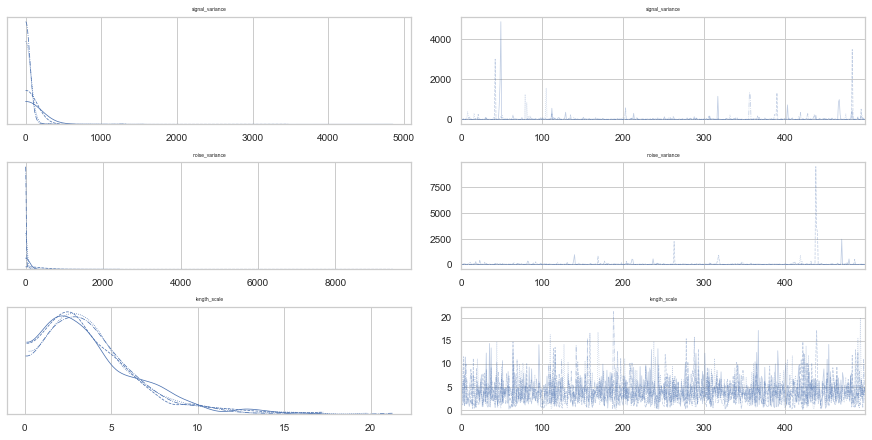

In [22]:
pm.traceplot(posterior, varnames=["signal_variance", "noise_variance", "length_scale"]);

In [39]:
pm.gelman_rubin(posterior, varnames=["signal_variance", "noise_variance", "length_scale"])

<xarray.Dataset>
Dimensions:          ()
Data variables:
    signal_variance  float64 1.003
    noise_variance   float64 0.9995
    length_scale     float64 1.003

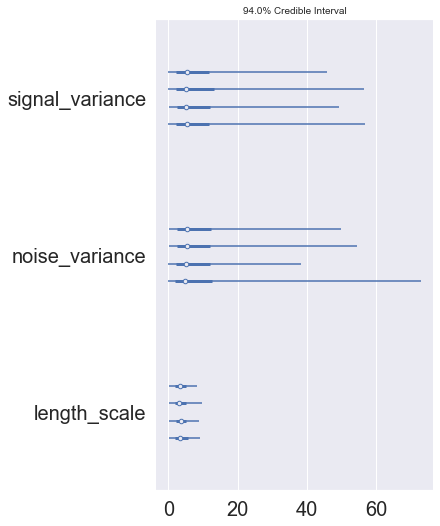

In [40]:
pm.forestplot(posterior, varnames=["signal_variance", "noise_variance", "length_scale"]);

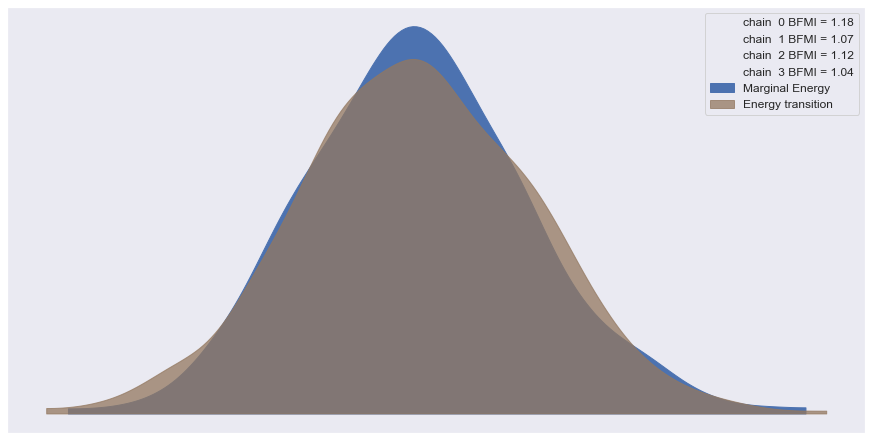

In [41]:
pm.energyplot(posterior)

## Step 5: Critize the model

In [42]:
pm.summary(posterior, varnames=["signal_variance", "noise_variance", "length_scale"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
signal_variance,27.685,178.687,0.002,52.693,4.920,3.480,1319.0,1319.0,2448.0,1081.0,1.0
noise_variance,27.975,253.932,0.012,53.814,8.322,5.886,931.0,931.0,2457.0,1216.0,1.0
length_scale,3.958,2.803,0.074,8.931,0.050,0.045,3146.0,1923.0,2973.0,1277.0,1.0


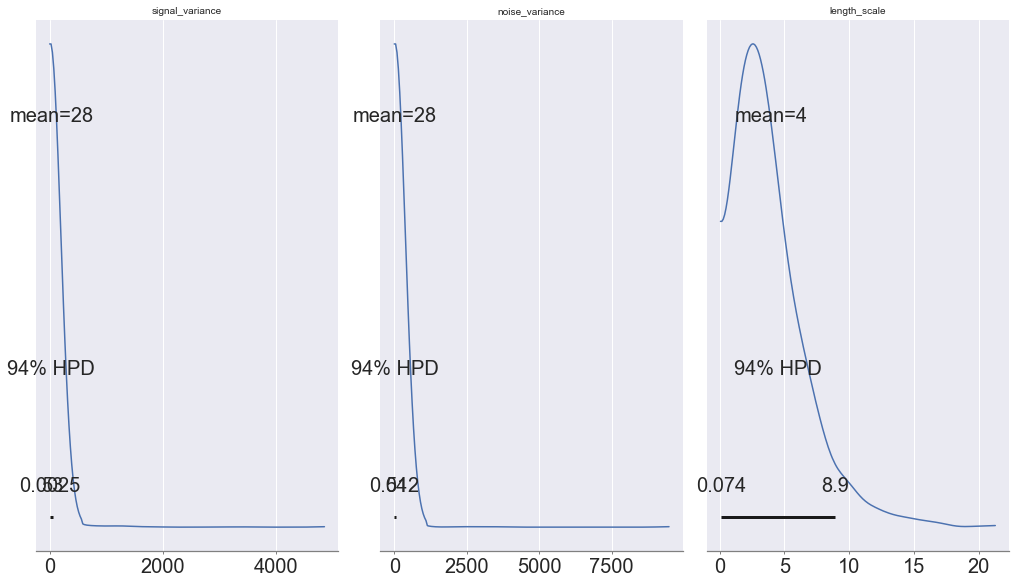

In [43]:
pm.plot_posterior(posterior, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

Text(0.5, 0, 'Inputs, X')

Text(0, 0.5, 'Outputs, Y')

Text(0.5, 1.0, 'Posterior distribution of $f(x)$ at the observed values')

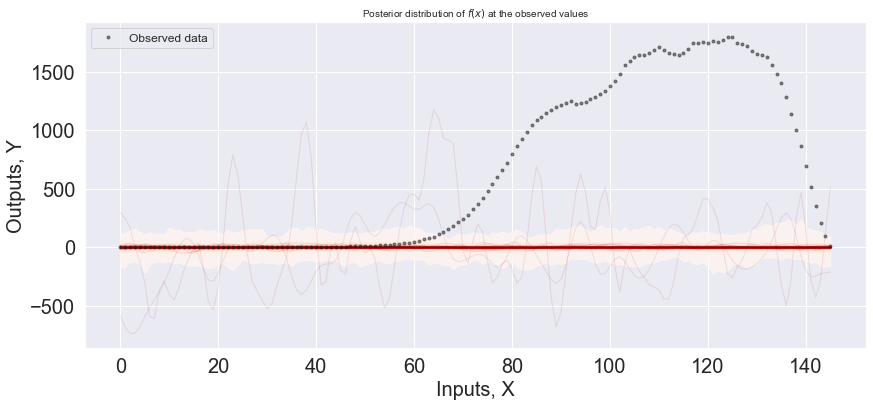

In [129]:
# plot the results
fig2 = plt.figure(figsize = (14, 6))
ax = fig2.gca()

# plot the samples of the gp posterior
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, posterior["theta"], X)

# plot the data and the true function
plt.plot(X, y, "ok", ms = 3, alpha = 0.5, label = "Observed data")

# axis labels and title
plt.xlabel("Inputs, X"); plt.ylabel("Outputs, Y")
plt.title("Posterior distribution of $f(x)$ at the observed values")
plt.legend()

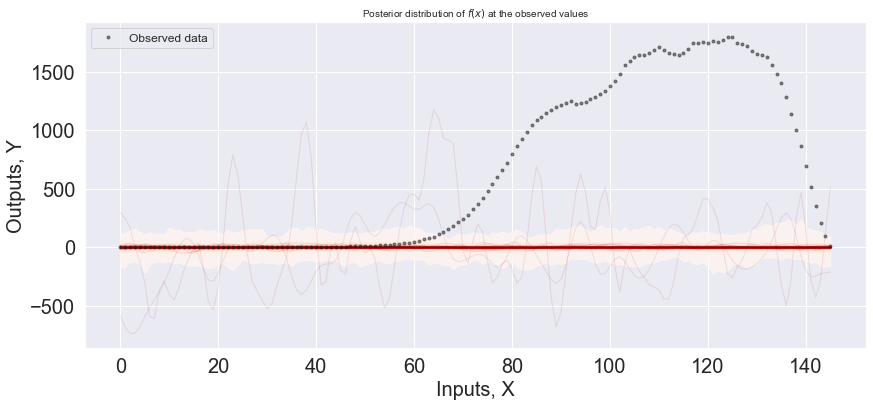

In [130]:
fig2

## Step 6: Use the model for prediction

In [45]:
# prepare test dataset
# 30 new values from x=147 to x=177
n_new = 30
X_new = np.arange(start=147, stop=177)[:,None]

In [46]:
X_new

array([[147],
       [148],
       [149],
       [150],
       [151],
       [152],
       [153],
       [154],
       [155],
       [156],
       [157],
       [158],
       [159],
       [160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167],
       [168],
       [169],
       [170],
       [171],
       [172],
       [173],
       [174],
       [175],
       [176]])

In [47]:
# extend the model by adding the GP conditional distribution so as to predict at test data
with rt_model:
    f_pred = gp.conditional("f_pred", X_new)

In [48]:
# sample from the GP conditional posterior
with rt_model:
    posterior_pred = pm.sample_ppc(posterior, vars = [f_pred], samples = 200)

100%|██████████| 200/200 [00:01<00:00, 116.39it/s]


NameError: name 'posterior_pred' is not defined

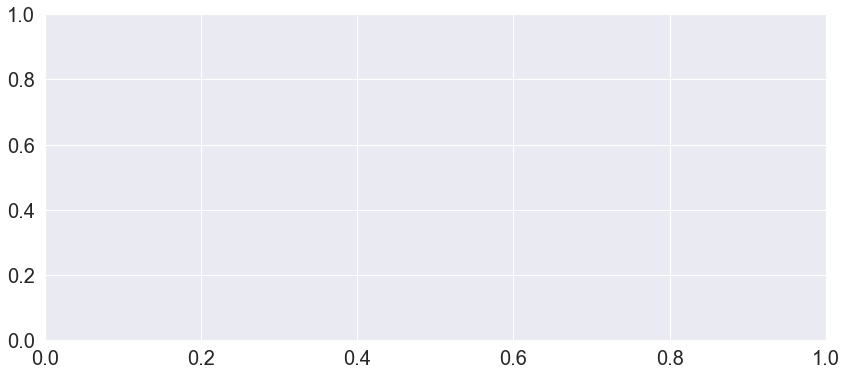

In [68]:
# plot the results
fig = plt.figure(figsize=(14,6)); ax = fig.gca()
plot_gp_dist(ax, posterior_pred["f_pred"], X_new,);
# plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("Cases");
plt.title("Conditional distribution of f_*, given f"); plt.legend();

### Save the posterior

In [26]:
# save the posterior to the file 'posterior_lm.pkl' for later use
with open('data/posterior_rt.pkl', 'wb') as f:
    pickle.dump(posterior, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# # load it at some future point
# with open('data/posterior_rt.pkl', 'rb') as f:
#     posterior = pickle.load(f)

In [90]:
results = pd.read_csv('data/rt_2020_05_25_gp_small.csv',
                      parse_dates=['date'],
                      index_col=['date'])                  

In [91]:
results

,region,mean,median,lower_90,upper_90,lower_50,upper_50
date,,,,,,,
2020-04-07,AK,0.963746,0.973863,0.606498,1.271240,0.887085,1.113360
2020-04-08,AK,0.960960,0.965341,0.657428,1.322876,0.866269,1.108430
2020-04-09,AK,0.960305,0.962564,0.597006,1.269404,0.827694,1.072009
2020-04-10,AK,0.958749,0.960853,0.585150,1.266613,0.832920,1.077451
2020-04-11,AK,0.956637,0.964426,0.612912,1.289218,0.812231,1.059646
...,...,...,...,...,...,...,...
2020-05-21,WY,0.981927,0.989202,0.666771,1.312433,0.884470,1.101710
2020-05-22,WY,0.981131,0.991832,0.633900,1.281591,0.910837,1.124067
2020-05-23,WY,0.981081,0.994668,0.640676,1.298298,0.921154,1.136839


In [101]:
result = results[results['region'] == 'AK']

Text(0.5, 1.0, 'AK')

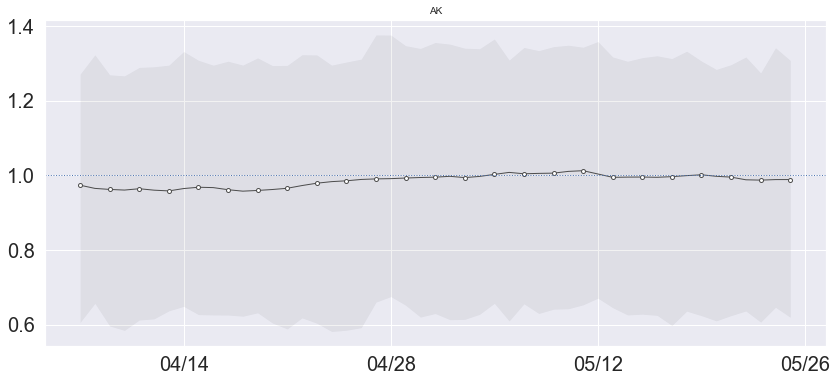

In [102]:
from matplotlib import dates as mdates
from matplotlib import ticker

c=(.3,.3,.3,1)
ci=(0,0,0,.05)

fig, ax = plt.subplots()
ax.set_title("AK")
ax.plot(result['median'],
        marker='o',
        markersize=4,
        markerfacecolor='w',
        lw=1,
        c=c,
        markevery=2)
ax.fill_between(
    result.index,
    result['lower_90'].values,
    result['upper_90'].values,
    color=ci,
    lw=0)
ax.axhline(1.0, linestyle=':', lw=1)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

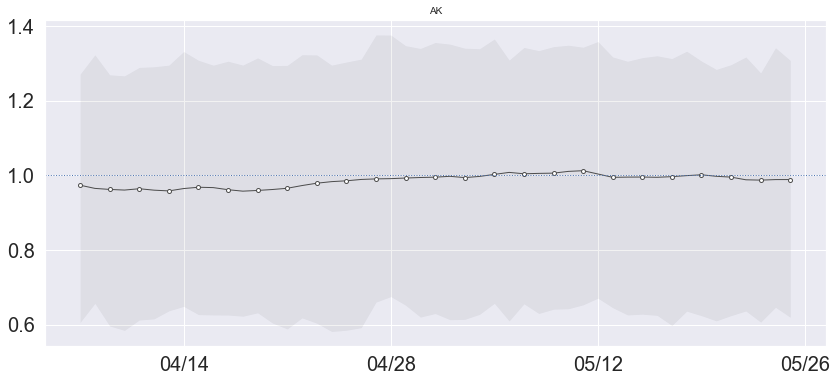

In [112]:
fig

## How do I quickly put my analysis infront of end users?

### Streamlit (https://www.streamlit.io/)

<table>
    <tr>
        <td>
            <a href="https://www.streamlit.io/gallery"><img src="https://assets.website-files.com/5dc3d949429c1addc4f8dac2/5e11152b0227d05a0277ae20_gan_website_large.gif" width="600"></a>
            <br>
        </td>
        <td>
            <a href="https://www.streamlit.io/gallery"><img src="https://camo.githubusercontent.com/5ae1dcfd188be26bbb0648fb62e9d6d593dbb6f5/68747470733a2f2f617773312e646973636f757273652d63646e2e636f6d2f7374616e6461726431302f75706c6f6164732f73747265616d6c69742f6f726967696e616c2f31582f323932653938356637663735656637626566386332376235383939663731663736636435373765302e676966" width="600"></a>
        </td>
    </tr>
</table>

## Next Steps with Probabilistic Programming

### PyMC3

The following books/GitHub repositories provide good introductions to PyMC3 and Bayesian statistics.

<table>
    <tr>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
        <td>
            <a href="https://www.amazon.com/Bayesian-Analysis-Python-Osvaldo-Martin-ebook/dp/B07CKQZ7V3"><img src="https://images-na.ssl-images-amazon.com/images/I/51ns1HxOPnL._SY346_.jpg" width=275></a>
        </td>
    </tr>
</table>

# Thank you

In [145]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=intro-pml-streamlit \
    ./01-modeling.ipynb

[NbConvertApp] Converting notebook ./01-modeling.ipynb to slides
[NbConvertApp] Writing 598637 bytes to ./intro-pml-streamlit.slides.html
